# Final Capstone Project Notebook
We will be exploring this [crop yield dataset from Kaggle](https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset?select=yield_df.csv) to understand how various features such as the rainfall, amount of pesticides used, etc. affects crop yields.

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
import time

## Import the dataset and explore the features available

In [2]:
# Load dataset
raw_data = pd.read_csv('data/yield_df.csv')

raw_data

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...,...
28237,28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


### Data Cleaning

The data does not contain any null values. Therefore, we do not need to drop any missing/NaN data points, or impute them from existing data.
However, the 'Unnamed: 0' column is unnecessary, so I will be dropping it.

In [4]:
raw_data.drop(columns='Unnamed: 0', inplace=True)

### Exploring the categorical features

Let's understand our categorical features better

In [5]:
raw_data['Area'].value_counts()

Area
India         4048
Brazil        2277
Mexico        1472
Pakistan      1449
Japan          966
              ... 
Estonia         42
Belgium         39
Bahrain         29
Sudan           28
Montenegro      24
Name: count, Length: 101, dtype: int64

In [6]:
raw_data['Item'].value_counts()

Item
Potatoes                4276
Maize                   4121
Wheat                   3857
Rice, paddy             3388
Soybeans                3223
Sorghum                 3039
Sweet potatoes          2890
Cassava                 2045
Yams                     847
Plantains and others     556
Name: count, dtype: int64

'Area' seems to refer to the country, so let's rename that column. Similarly, 'Item' is the crop that was planted.

In addition to these categorical features, I will rename some of the numerical features in the step below for readability.

In [7]:
raw_data.rename(columns={
    'Area':'Country',
    'Item':'Crop',
    'hg/ha_yield':'Yield',
    'average_rain_fall_mm_per_year':'Rainfall',
    'pesticides_tonnes':'Pesticides',
    'avg_temp':'Temperature'
}, inplace=True)

### Exploring the numerical features

Now that our column names are more readable, let's take a closer look at the numerical features' distributions.

In [8]:
raw_data.describe()

,Year,Yield,Rainfall,Pesticides,Temperature
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


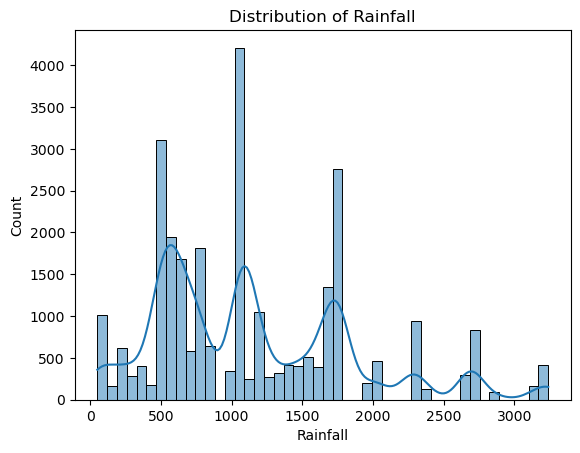

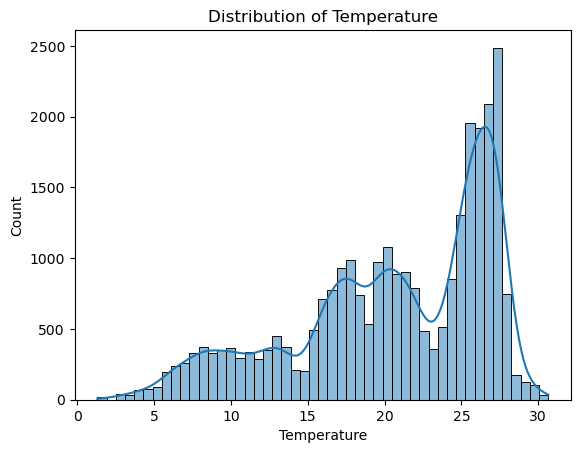

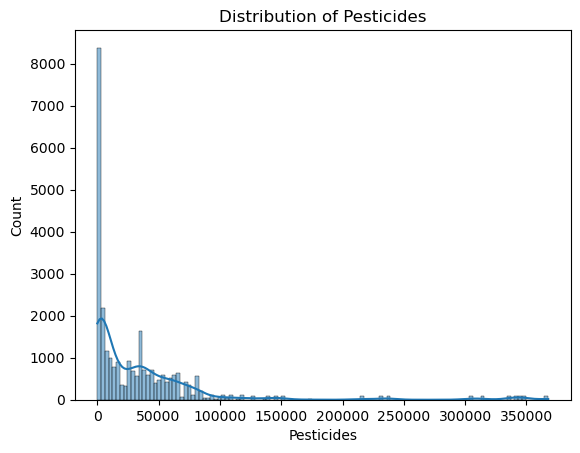

In [9]:
sns.histplot(raw_data['Rainfall'], kde=True)
plt.title('Distribution of Rainfall')
plt.show()

sns.histplot(raw_data['Temperature'], kde=True)
plt.title('Distribution of Temperature')
plt.show()

sns.histplot(raw_data['Pesticides'], kde=True)
plt.title('Distribution of Pesticides')
plt.show()

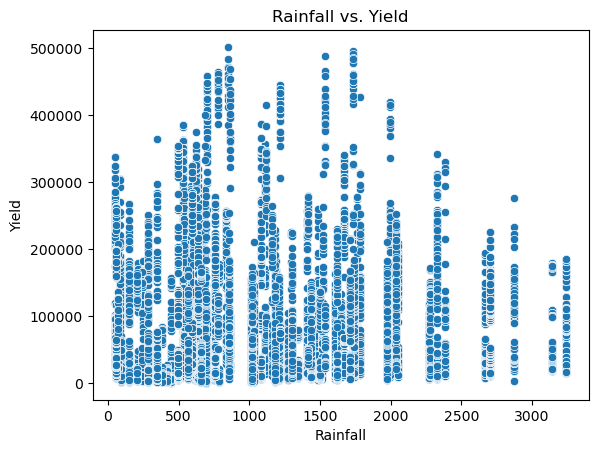

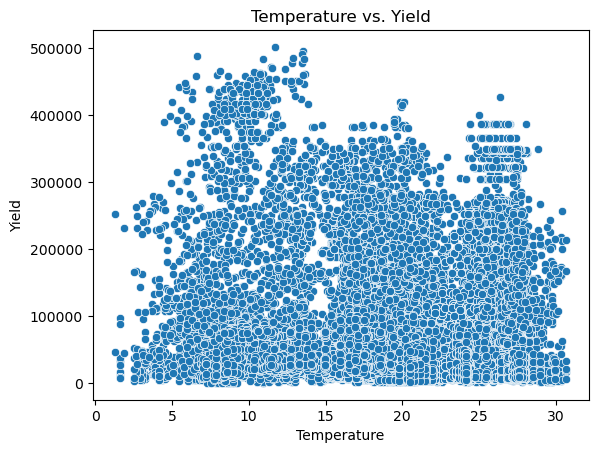

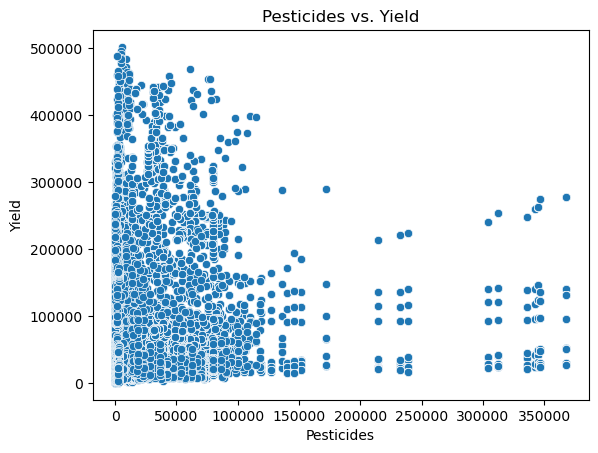

In [10]:
sns.scatterplot(x='Rainfall', y='Yield', data=raw_data)
plt.title('Rainfall vs. Yield')
plt.show()

sns.scatterplot(x='Temperature', y='Yield', data=raw_data)
plt.title('Temperature vs. Yield')
plt.show()

sns.scatterplot(x='Pesticides', y='Yield', data=raw_data)
plt.title('Pesticides vs. Yield')
plt.show()

The distributions of the features Temperature and Rainfall look good.

However, the distribution of Pesticides is heavily right-skewed. Models perform well on data similar to which they were trained on. If datapoints for Pesticides happens to be too far outside what is "normal" for the training data, we will see poor results.  
To tackle this, I will apply a logarithmic transformation to the Pesticides column to normalize its distribution.
> (np.log1p was used to avoid negative values after transformation)

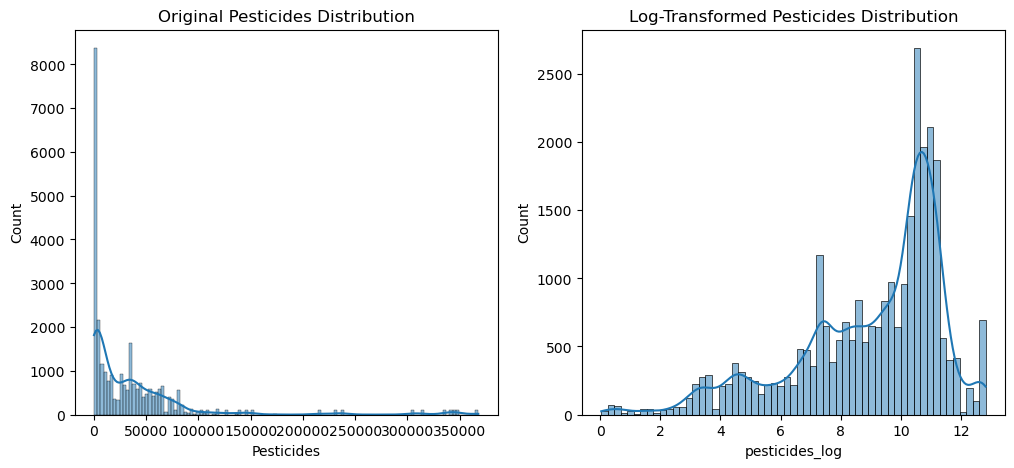

In [11]:
raw_data['pesticides_log'] = np.log1p(raw_data['Pesticides'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Original distribution
sns.histplot(raw_data['Pesticides'], kde=True, ax=ax[0])
ax[0].set_title('Original Pesticides Distribution')
# Transformed distribution
sns.histplot(raw_data['pesticides_log'], kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Pesticides Distribution')

plt.show()

Now the 'Pesticides' feature is looking much better!

Let's take a look at the distribution of our target: Yield

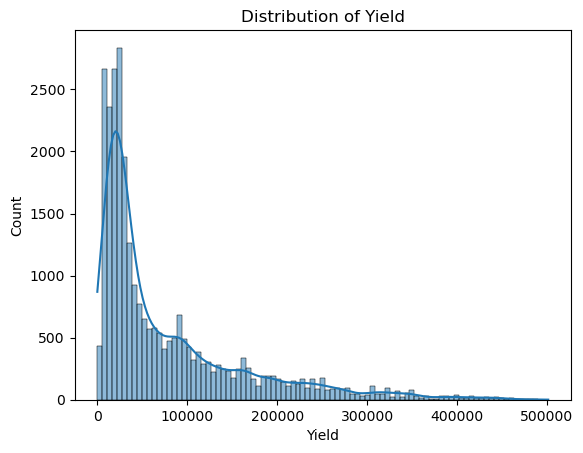

In [12]:
sns.histplot(raw_data['Yield'], kde=True)
plt.title('Distribution of Yield')
plt.show()

Since we observe a similar right-skew, I will be transforming the Yield using a logarithmic scale as well.

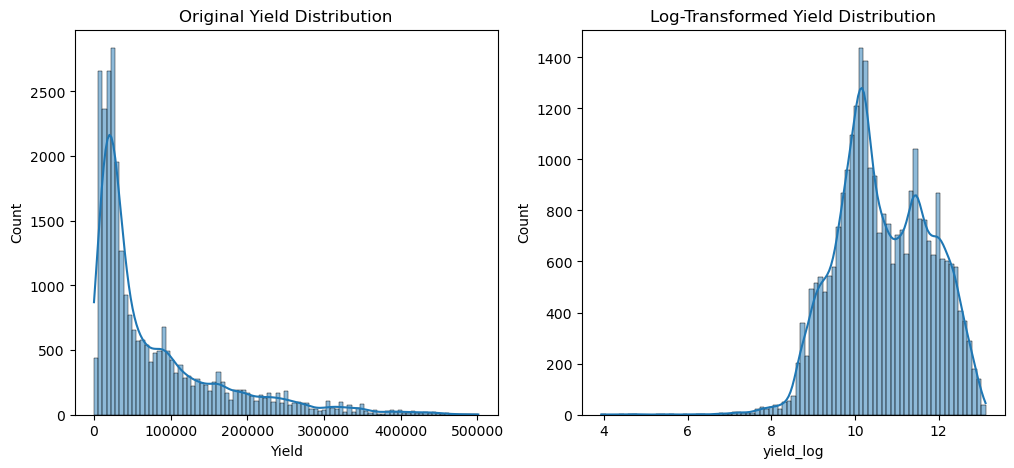

In [13]:
raw_data['yield_log'] = np.log1p(raw_data['Yield'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Original distribution
sns.histplot(raw_data['Yield'], kde=True, ax=ax[0])
ax[0].set_title('Original Yield Distribution')
# Transformed distribution
sns.histplot(raw_data['yield_log'], kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Yield Distribution')

plt.show()

## Generating Lag Features using the 'Year' data

In [14]:
raw_data = raw_data.sort_values(by=['Country', 'Crop', 'Year'])

raw_data['rainfall_lag1'] = raw_data.groupby(['Country', 'Crop'])['Rainfall'].shift(1)
raw_data['temperature_lag1'] = raw_data.groupby(['Country', 'Crop'])['Temperature'].shift(1)
raw_data['pesticides_log_lag1'] = raw_data.groupby(['Country', 'Crop'])['pesticides_log'].shift(1)

raw_data = raw_data.dropna()
raw_data = raw_data.sort_index()

In [15]:
raw_data.head()

,Country,Crop,Year,Yield,Rainfall,Pesticides,Temperature,pesticides_log,yield_log,rainfall_lag1,temperature_lag1,pesticides_log_lag1
6,Albania,Maize,1991,29068,1485.0,121.0,15.36,4.804021,10.277428,1485.0,16.37,4.804021
7,Albania,Potatoes,1991,77818,1485.0,121.0,15.36,4.804021,11.262141,1485.0,16.37,4.804021
8,Albania,"Rice, paddy",1991,28538,1485.0,121.0,15.36,4.804021,10.259027,1485.0,16.37,4.804021
9,Albania,Sorghum,1991,6667,1485.0,121.0,15.36,4.804021,8.805075,1485.0,16.37,4.804021
10,Albania,Soybeans,1991,6066,1485.0,121.0,15.36,4.804021,8.710620,1485.0,16.37,4.804021


Now that our features are finally set up how we want, we can move into the modeling portion of the project.

In [16]:
df = raw_data

## Preprocessing Steps

In [17]:
categorical_features = ['Country', 'Crop']
numerical_features = ['Rainfall', 'Temperature', 'pesticides_log', 'rainfall_lag1', 'temperature_lag1', 'pesticides_log_lag1']

In [18]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

numerical_poly_transformer = Pipeline(steps=[
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numerical_poly_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Defining Pipelines
We will be testing out six different combinations of modeling algorithms on the data

In [19]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

pipeline_poly_sfs = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('selector', SequentialFeatureSelector(LinearRegression())),
    ('regressor', LinearRegression())
])

pipeline_ridge_sfs = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('selector', SequentialFeatureSelector(Ridge())),
    ('regressor', Ridge())
])

pipeline_lasso_sfs = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('selector', SequentialFeatureSelector(Lasso())),
    ('regressor', Lasso())
])

pipeline_ridge_sfs_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('selector', SequentialFeatureSelector(Ridge())),
    ('regressor', LinearRegression())
])

pipeline_lasso_sfs_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('selector', SequentialFeatureSelector(Lasso())),
    ('regressor', LinearRegression())
])

## Defining hyperparameters to test via GridSearchCV

In [20]:
param_grid_lr = {}  # No hyperparameters to tune for Linear Regression, acting as our control/baseline model.

param_grid_ridge = {
    'regressor__alpha': [0.1, 1.0, 10.0]
}

param_grid_lasso = {
    'regressor__alpha': [0.1, 1.0, 10.0]
}

param_grid_poly_sfs = {
    'selector__n_features_to_select': [6, 8, 10]
}

param_grid_ridge_sfs = {
    'regressor__alpha': [0.1, 1.0, 10.0],
    'selector__n_features_to_select': [6, 8, 10]
}

param_grid_lasso_sfs = {
    'regressor__alpha': [0.1, 1.0, 10.0],
    'selector__n_features_to_select': [6, 8, 10]
}

param_grid_ridge_sfs_lr = {
    'selector__n_features_to_select': [6, 8, 10]
}

param_grid_lasso_sfs_lr = {
    'selector__n_features_to_select': [6, 8, 10]
}

## Splitting data into Training and Testing datasets

In [21]:
X = df.drop(columns=['Yield', 'yield_log', 'Pesticides', 'Year'])
y = df['yield_log']  # Using log-transformed yield

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Defining function to use for GridSearchCV through different models and hyperparameter lists

In [22]:
def perform_grid_search(pipeline, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = time.time() - start_time

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    return best_model, best_params, fit_time, train_mse, test_mse

## Fitting data to all model and parameter combinations using GridSearchCV

In [23]:
results = []
best_models = {}
models = [
    ('Linear Regression', pipeline_lr, param_grid_lr),
    ('Ridge Regression', pipeline_ridge, param_grid_ridge),
    ('Lasso Regression', pipeline_lasso, param_grid_lasso),
    ('Polynomial Regression with SFS', pipeline_poly_sfs, param_grid_poly_sfs),
    ('Ridge Regression with SFS', pipeline_ridge_sfs, param_grid_ridge_sfs),
    ('Lasso Regression with SFS', pipeline_lasso_sfs, param_grid_lasso_sfs),
    ('Ridge SFS with Linear Regression', pipeline_ridge_sfs_lr, param_grid_ridge_sfs_lr),
    ('Lasso SFS with Linear Regression', pipeline_lasso_sfs_lr, param_grid_lasso_sfs_lr)
]

for model_name, pipeline, param_grid in models:
    best_model, best_params, fit_time, train_mse, test_mse = perform_grid_search(pipeline, param_grid, X_train, y_train, X_test, y_test)
    best_models[model_name] = best_model
    results.append({
        'Model': model_name,
        'Best Parameters': best_params,
        'Fit Time': fit_time,
        'Train MSE': train_mse,
        'Test MSE': test_mse
    })

results_df = pd.DataFrame(results)

## Analyzing Results

In [24]:
results_df

,Model,Best Parameters,Fit Time,Train MSE,Test MSE
0,Linear Regression,{},2.171997,0.209096,0.211012
1,Ridge Regression,{'regressor__alpha': 0.1},1.895002,0.209098,0.211039
2,Lasso Regression,{'regressor__alpha': 0.1},0.692002,0.871452,0.884591
3,Polynomial Regression with SFS,{'selector__n_features_to_select': 10},73.143001,0.304379,0.311659
4,Ridge Regression with SFS,"{'regressor__alpha': 0.1, 'selector__n_feature...",157.308000,0.304379,0.311659
5,Lasso Regression with SFS,"{'regressor__alpha': 0.1, 'selector__n_feature...",177.602000,1.189351,1.202631
6,Ridge SFS with Linear Regression,{'selector__n_features_to_select': 10},77.774000,0.304379,0.311659
7,Lasso SFS with Linear Regression,{'selector__n_features_to_select': 10},102.505000,1.156216,1.161822


In [25]:
for model_name, model in best_models.items():
    if 'selector' in model.named_steps:
        selector = model.named_steps['selector']
        selected_features = selector.get_support(indices=True)
        print(f"Selected features for {model_name}: {selected_features}")

Selected features for Polynomial Regression with SFS: [  5  25 128 129 130 131 132 135 136 137]
Selected features for Ridge Regression with SFS: [  5  25 128 129 130 131 132 135 136 137]
Selected features for Lasso Regression with SFS: [0 1 2 3 4 5]
Selected features for Ridge SFS with Linear Regression: [  5  25 128 129 130 131 132 135 136 137]
Selected features for Lasso SFS with Linear Regression: [0 1 2 3 4 5 6 7 8 9]


### Plotting training times and train/test errors

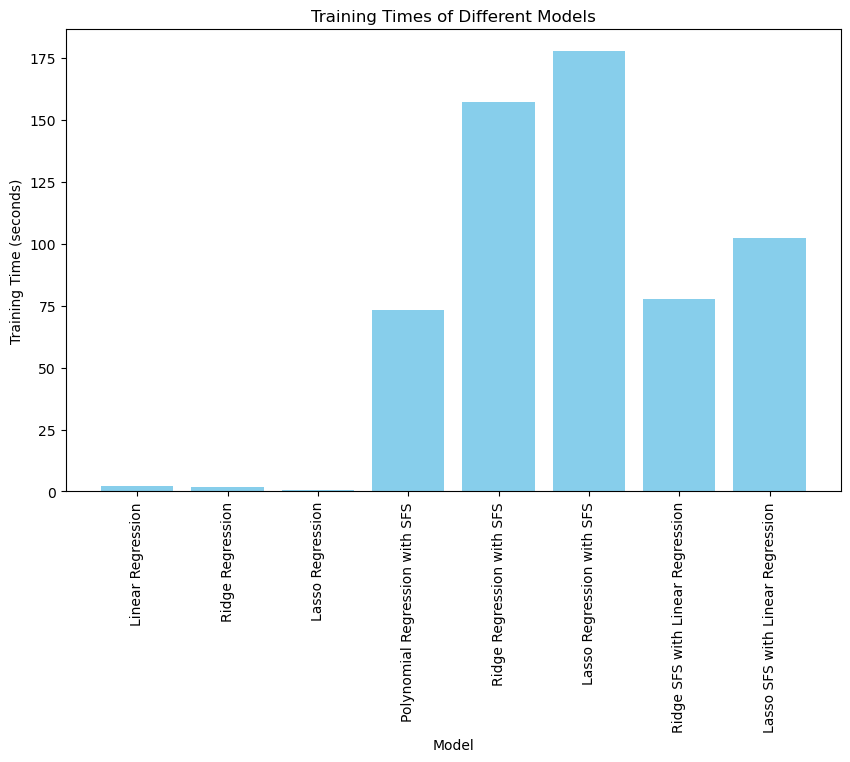

In [26]:
# Bar plot of training times
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Fit Time'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Times of Different Models')
plt.xticks(rotation=90)
plt.show()

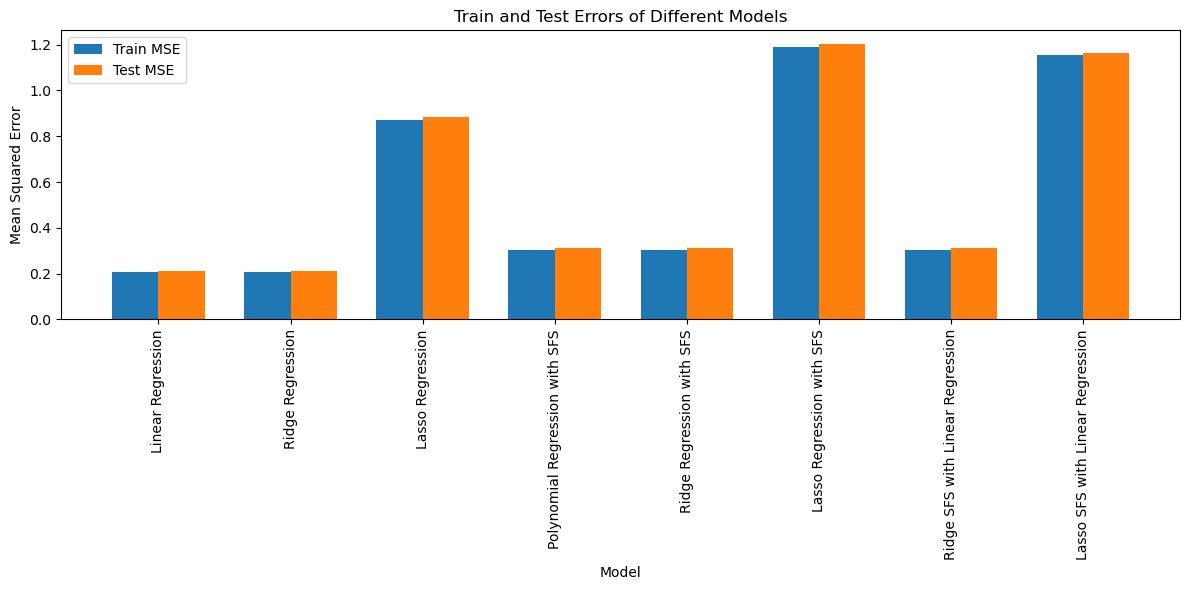

In [27]:
# Bar plot of errors (train and test)
x = np.arange(len(results_df['Model']))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, results_df['Train MSE'], width, label='Train MSE')
rects2 = ax.bar(x + width/2, results_df['Test MSE'], width, label='Test MSE')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Train and Test Errors of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=90)
ax.legend()

fig.tight_layout()
plt.show()

### Permutation importance of features in each model

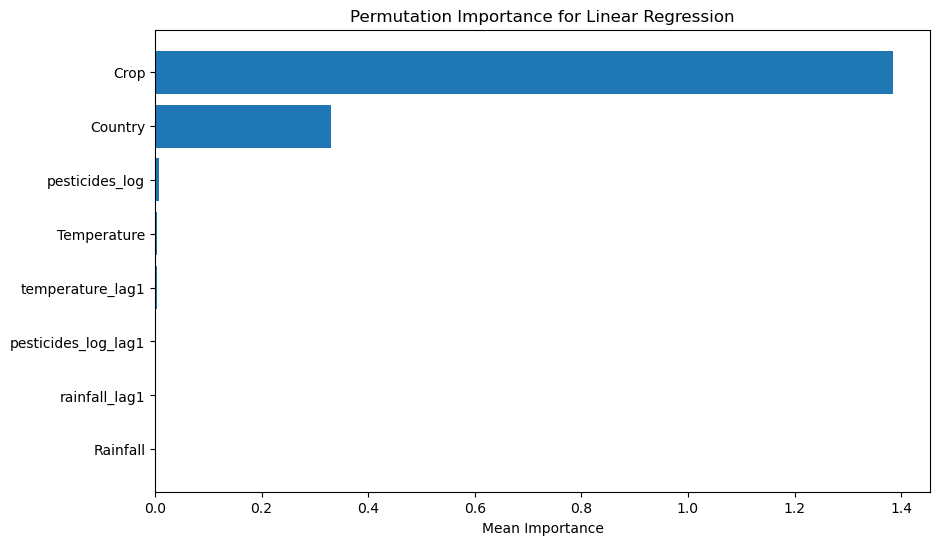

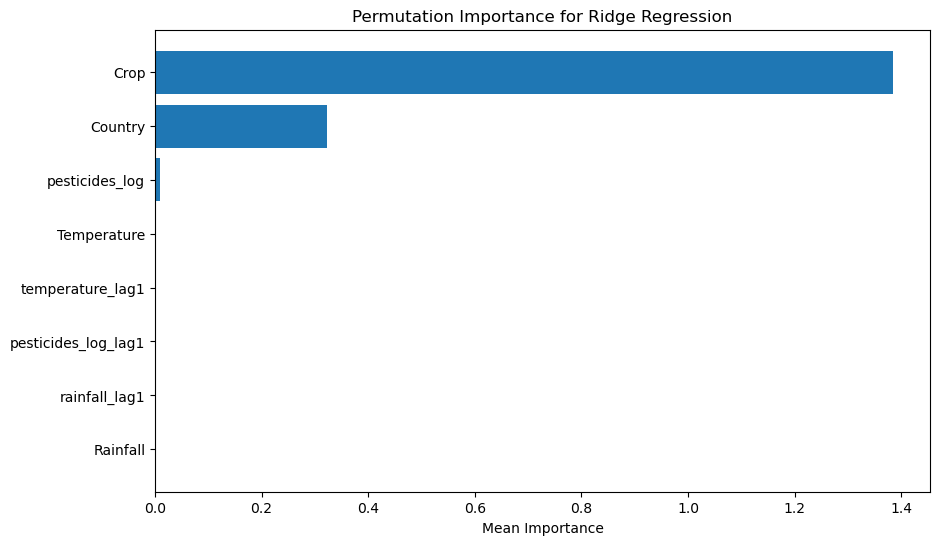

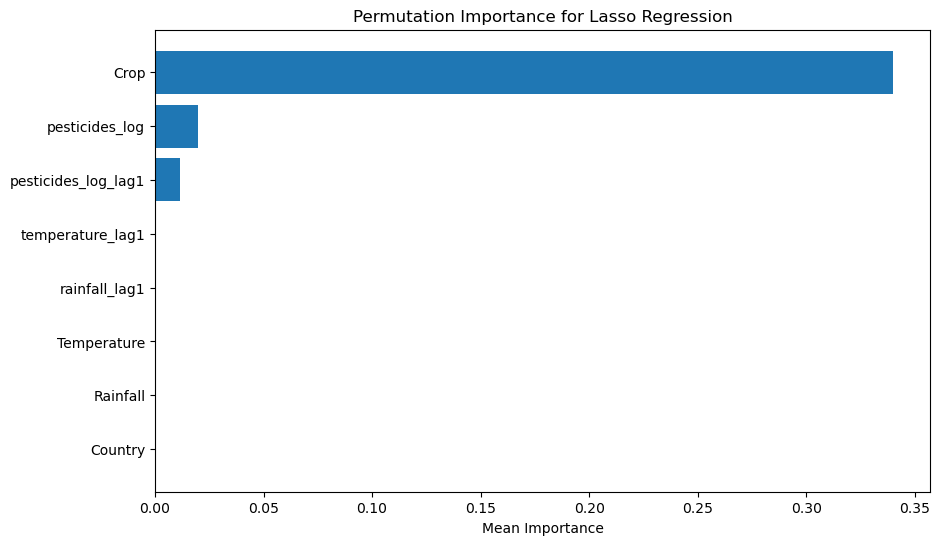

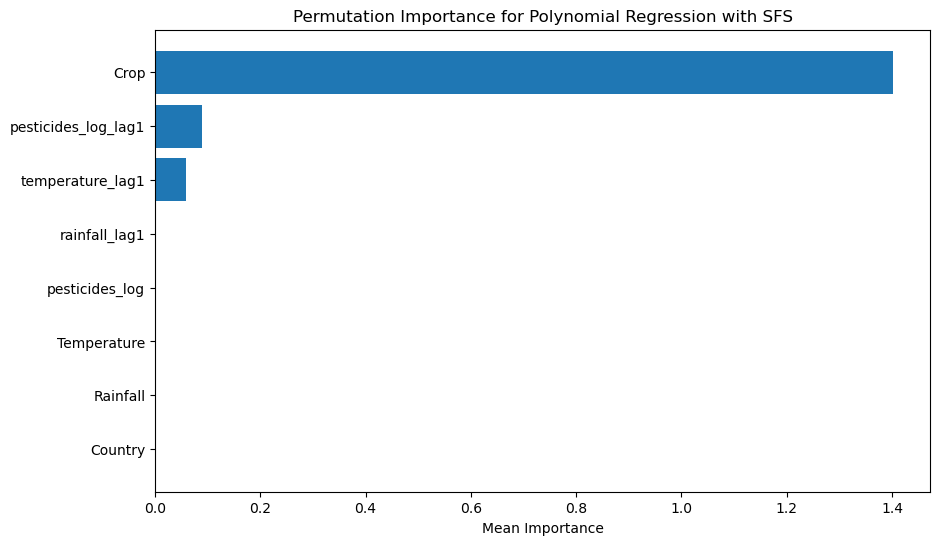

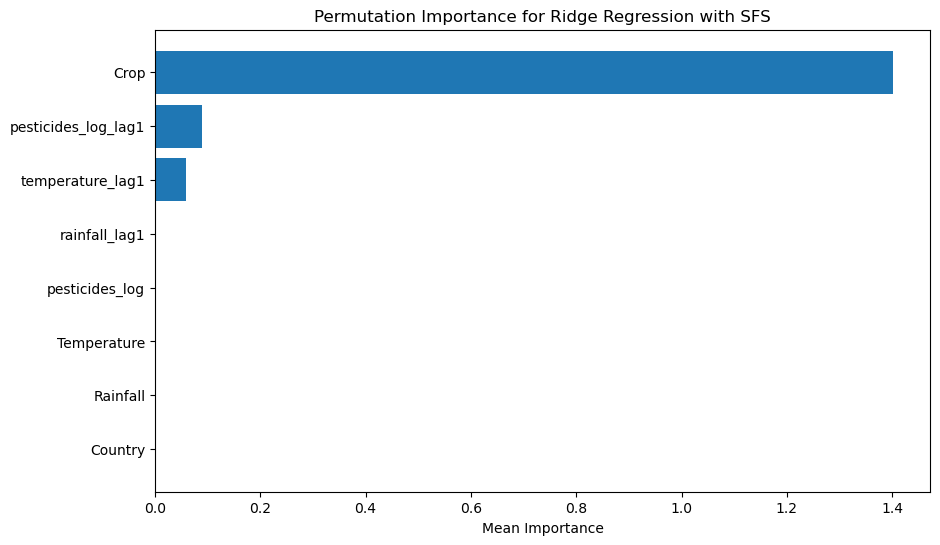

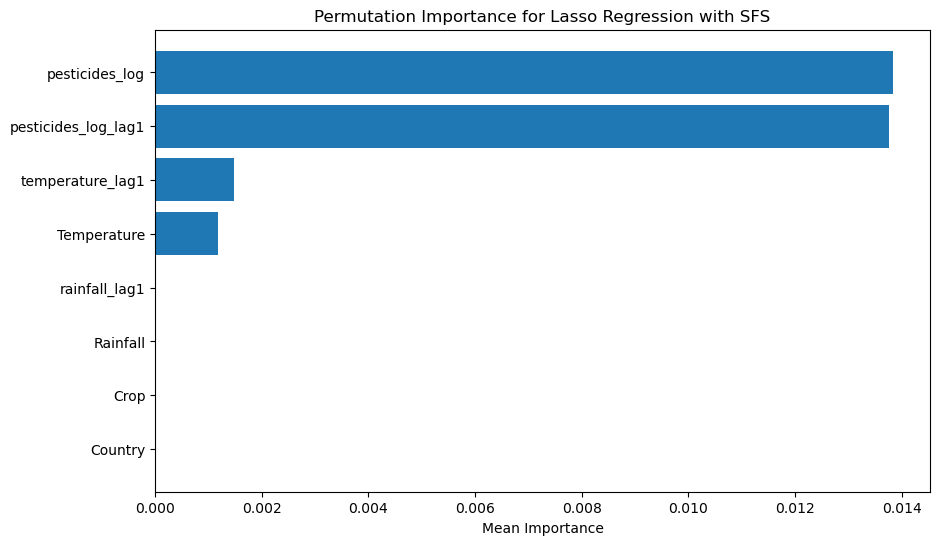

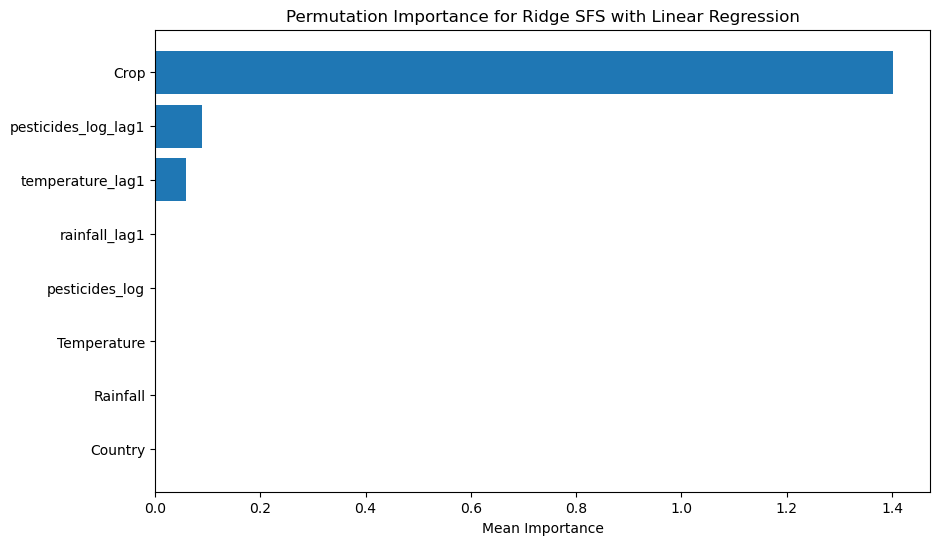

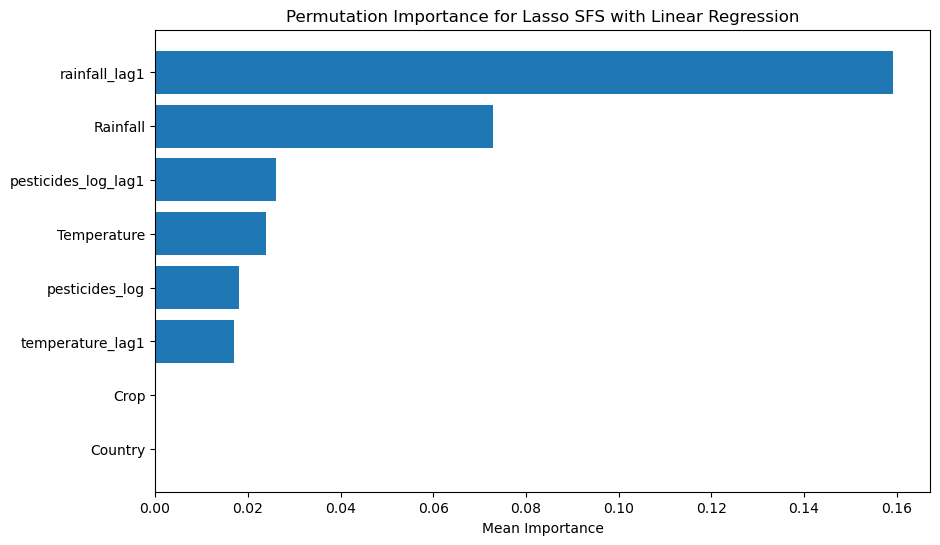

In [28]:
# Permutation importance on the best models
for model_name, model in best_models.items():
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = result.importances_mean.argsort()
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.xlabel('Mean Importance')
    plt.title(f'Permutation Importance for {model_name}')
    plt.show()

## Conclusion

Based on the analysis performed above, it appears that the model which performed the best was a simple Linear Regression. The model that employed Ridge regression with alpha=0.1 had a very comparable performance.  
These models had a test MSE of 0.211012 and 0.211039 respectively.

The models chose that the 'Crop' and 'Country' had the biggest influence on the overall yield, as seen in the permuation_importance graphs.